In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit.circuit.library import QFT

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
"""Creates a list of sub-circuits of a QuantumCircuit"""

'Creates a list of sub-circuits of a QuantumCircuit'

In [3]:
# Setup simulators
state_vector_sim = Aer.get_backend('statevector_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

# Define helper functions
def get_state_vector(circuit):
    return state_vector_sim.run(circuit).result().get_statevector()

def get_unitary_matrix(circuit):
    return execute(circuit, unitary_sim).result().get_unitary()

# Pretty-printing
def print_matrix(matrix):
    for row in matrix:
        for num in row:
            print(f"{np.around(num, 2)}   ", end='')
        print('')
    print('\n---')
    
def print_state_vector(svec):
    for num in svec:
        print(np.around(num, 2))
    print('---')

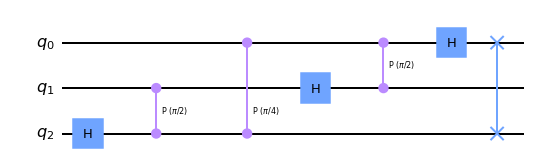

In [4]:
# Place circuit here
circuit = QFT(3)

# GHZ
# circuit = QuantumCircuit(3)
# circuit.h(0)
# circuit.cx(0, 1)
# circuit.cx(0, 2)

circuit.draw()

In [5]:
# Each sub-circuit will have the same number of qubits as the original circuit
num_qubits = circuit.num_qubits
sub_circuits = []

# https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.data
for (insn, qargs, cargs) in circuit.data:
    #print(insn)
    #print(qargs)
    #print(cargs)
    sub_circuit = QuantumCircuit(num_qubits)
    
    #state_vector = get_state_vector(sub_circuit)
    #print_state_vector(state_vector)
    
    #unitary_matrix = get_unitary_matrix(circuit)
    #print_matrix(unitary_matrix)
    
    # https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.append
    sub_circuit.append(insn, qargs, cargs)
    sub_circuits.append(sub_circuit)

print('%i sub circuits' % len(sub_circuits))

7 sub circuits


In [6]:
# Unfortunately we can't print each sub-circuit in a for-loop...
for sub_circuit in sub_circuits:
    print('Test print')
    sub_circuit.draw()

Test print
Test print
Test print
Test print
Test print
Test print
Test print


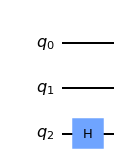

In [7]:
# Printing individually works
sub_circuits[0].draw()

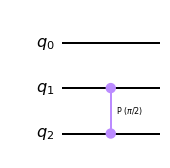

In [8]:
sub_circuits[1].draw()

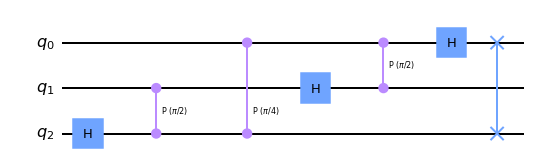

In [9]:
# Check if the combined circuit looks like the original
combined_circuit = sub_circuits[0]
for i in range(1, len(sub_circuits)):
    # https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.compose
    combined_circuit = combined_circuit.compose(sub_circuits[i])
    # combined_circuit += sub_circuits[i]

# Print combined circuit
combined_circuit.draw()

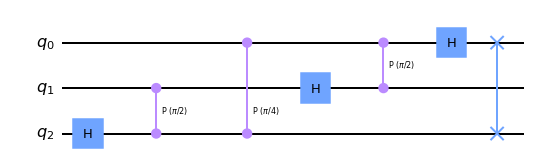

In [10]:
# Print original
circuit.draw()

In [11]:
# Compare the combined circuit with the original
if combined_circuit == circuit:
    print('It worked!!!')
else:
    print('It failed...')

True